In [2]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

In [5]:
from opentn.channels import get_krauss_from_unitary
from opentn.circuits import get_unitary_adchannel
from opentn.states.qubits import up, down, plus, minus
from opentn.tensors import MPOP
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# First I will construct the krauss operators corresponding to a small time step for the amplitude damping channel.
# I should mention, however, that here there is not hamitlonian, beacause we are looking at it in the interaction picture
# after I build the krauss operators, I can evolve it n times to reach a certain t = n*dt and compare with the gamma corresponding to the total time
# using the actual krauss operators from 'purifications_tn.ipynb'

t = 1 #np.log(2)
gamma_init = 1 #normalized for iniital gamma
gamma =  1 - np.exp(-gamma_init*t)
print(gamma)
# This is if we had access to the full unitary, from which we can get the krauss operators
krauss_list_t = get_krauss_from_unitary(get_unitary_adchannel(gamma=gamma))

# initial state: fixed here
phys_init = plus
A = MPOP.create_purified([phys_init])

A.apply_krauss_operators(krauss_list=krauss_list_t)
rho_purified_t = A.get_density_matrix()
rho_purified_t

0.6321205588285577


array([[0.81606028+0.j, 0.30326533+0.j],
       [0.30326533+0.j, 0.18393972+0.j]])

In [4]:
# now let's do dt = t/n for different n
ns = np.linspace(1,20,20, dtype=int)
norms_n = []
for n in ns:
    dt = t/n
    k0_dt = np.array([[1,0],[0,1-dt*gamma_init/2]], dtype=complex)
    k1_dt = np.array([[0, np.sqrt(dt*gamma_init)],[0,0]], dtype=complex)
    krauss_list_dt = [k0_dt, k1_dt]
    A = MPOP.create_purified([phys_init])
    for _ in range(n):
        A.apply_krauss_operators(krauss_list=krauss_list_dt)
    rho_purified_dt = A.get_density_matrix()
    rho_purified_dt
    norm = np.linalg.norm(rho_purified_t-rho_purified_dt, ord='fro')
    norms_n.append(norm)

Text(0, 0.5, 'norm difference')

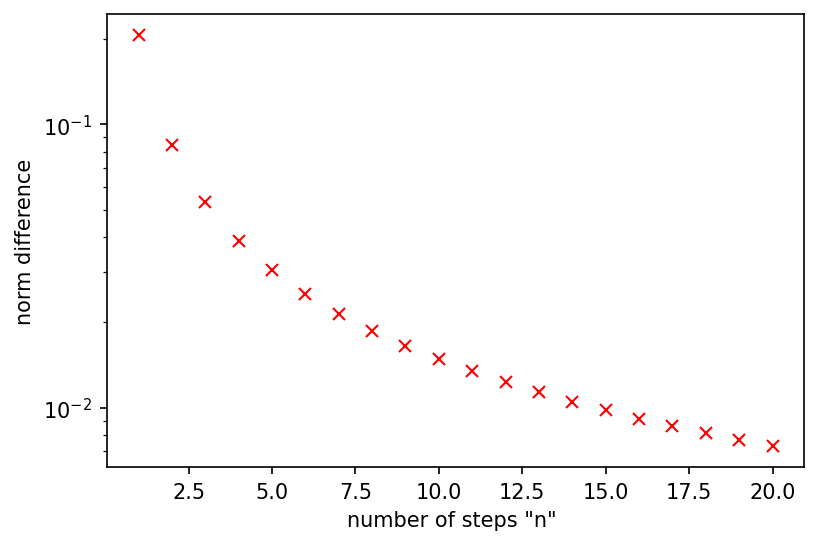

In [5]:
plt.figure(dpi=150)
plt.semilogy(ns, norms_n, 'rx')
plt.xlabel('number of steps "n" ')
plt.ylabel('norm difference')

# <center> Lindbladian evolution: 
## <center> superoperator ("exact") vs MPOP with Kraus operators

The interesting thing to do would be to have lindbladian acting on more than one site and getting the kraus operators for those.
So what troterization do I want to do exactly?
HOW WOULD THIS LOOK LIKE?
1. Look for a lindbladian that has terms acting on nearest neighbour sites
2. split $e^{\tau \mathcal{L}}$ (superoperator) into odd and even terms such: 
$$ e^{\tau \mathcal{L}} = e^{\tau \mathcal{L_o}/2} e^{\tau \mathcal{L_e}}  e^{\tau \mathcal{L_o}/2} + \mathcal{O}(\tau^3)$$
3. Apply each layer (odd-> even -> odd)
4. The trick is: the two site jump operators imply that we decompose the operators back to their individual tensors!

In [6]:
from opentn.states.qubits import get_ladder_operator
from opentn.transformations import lindbladian2super

In [5]:
# As a first step: lets try to just simulate the evolution when applying single site jump operators.
# compare to the exact solver. This could go along the lines of:
# vectorizing density matrix, using lindbladian to superoperator convert (then exp), then getting the final density matrix
gamma_adc = 0.5
dt = 1
gamma_lind = -np.log(1-gamma_adc)/dt

L1 = np.sqrt(gamma_lind)*get_ladder_operator() # sigma-
# L2 = np.sqrt(gamma)*get_ladder_operator(adjoint=True) #sigma+
Li = [L1]
superop = lindbladian2super(Li=Li, dim=2)

## <center> 1. Lindbladian: Kitaev's wire

In [3]:
from opentn.states.qubits import plus
from opentn.transformations import dissipative2liouvillian_full, op2fullspace, ket2dm, vectorize, unvectorize, find_nonzero, vectorize_dissipative
from scipy.linalg import expm

In [7]:
# Hamiltonian: spinless fermion chain
# Lindbladian: single lindbladian channel for every pair of neighbouring sites. Kitaev's wire
# Parameters chosen for non-trivial topological phase. Source: Eisers, Positive approach.
lowering = get_ladder_operator()
raising = get_ladder_operator(adjoint=True)
gamma = 1e-2 # lindbladian parameter
N = 2 # physical qubits
d = 2 # assume d is the physical dimension for all the sites. implicit also in our rising and lowering operators

# I THINK THIS METHOD IS WRONG BECAUSE WE ARE BASICALLY SAYING WE ONLY HAVE ONE LINDBLADIAN
# Lnn = np.zeros(shape=(d**N, d**N), dtype=complex)
# for i in range(0, N-1): # no periodic boundary conditions
#     Lnn += (op2fullspace(raising, i=i, N=N) + op2fullspace(raising, i=i+1, N=N))@(op2fullspace(lowering, i=i, N=N) - op2fullspace(lowering, i=i+1, N=N))
# Lnn *= np.sqrt(gamma)/4
# Lnnvec1 = vectorize_dissipative(Lnn)

In [8]:
# that thing was kind of wrong for my purposes. Let me re-do it. Instead lets just define a function that vectorizes l_nnndbladian terms
I = np.eye(d, dtype=complex)
NN = 2
# Create nearest neighbour lindbladian operator
Lnn = np.sqrt(gamma)*(op2fullspace(raising, i=0, N=NN) + op2fullspace(raising, i=1, N=NN))@(op2fullspace(lowering, i=0, N=NN) - op2fullspace(lowering, i=1, N=NN))/4

# vectorize each of the terms and add them together
Lvec = np.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
for i in range(0, N-1):
    Lvec += dissipative2liouvillian_full(L=Lnn, i=i, N=N, num_sites=2)

effective_qubits = np.log2(Lvec.shape[0])
print(f'Effective number of qubits {effective_qubits}')

Effective number of qubits 4.0


In [9]:
# Exponentiatate to get time evolving liouvillian operator
t = 1
exp_Lvec = expm(Lvec*t) # this is the exp(\hat{L}) that we should apply to the vectorization of the initial density matrix.

In [8]:
# Create initial state. Lets put all of them in equal superposition but the first one
init_state = up
for i in range(N-1):
    init_state = np.kron(init_state,plus)

# convert to density matrix
init_state_dm = ket2dm(vec=init_state)

# vectorize
init_state_dm_vec = vectorize(init_state_dm)

# Apply liouvillian evolving operator
final_state_dm_vec = exp_Lvec @ init_state_dm_vec
final_state_dm = unvectorize(final_state_dm_vec)

In [9]:
np.allclose(final_state_dm_vec, init_state_dm_vec)

False

In [10]:
final_state_dm

array([[5.00000000e-01+0.j, 4.99687695e-01+0.j, 3.12304769e-04+0.j,
        0.00000000e+00+0.j],
       [4.99687695e-01+0.j, 4.99687695e-01+0.j, 6.24219401e-04+0.j,
        0.00000000e+00+0.j],
       [3.12304769e-04+0.j, 6.24219401e-04+0.j, 3.12304769e-04+0.j,
        0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j]])

# Apply this in a tensor network representation

In [10]:
from opentn.transformations import lindbladian2kraus

In [33]:
# Lnn will be our operator acting on every l, l+1 sites whether l is odd or even.

# Let us initialize a MPOP which has as first site up, and plus the rest.
init_state_mpop = MPOP.create_purified([up] + [plus]*(N-1))

# Lets create the kraus operators that we will apply to this initial state
kraus_list_lnn = lindbladian2kraus(Li=[Lnn])
print(kraus_list_lnn[0])

# get K dimension
K = len(kraus_list_lnn)
print(K)

[[ 0.00000000e+00+0.j  2.77382374e-18+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  2.49843831e-02+0.j -2.49843831e-02+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  2.49843831e-02+0.j -2.49843831e-02+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   1.60213475e-18+0.j]]
2


In [43]:
idx = 1
print(np.linalg.eigvals(kraus_list_lnn[idx]))
U, S, Vh = np.linalg.svd(kraus_list_lnn[idx])
print(S)
print(np.linalg.matrix_rank(kraus_list_lnn[idx], tol=1e-6))

[-0.99875078+0.j -1.        +0.j -1.        +0.j -1.        +0.j]
[1.         1.         1.         0.99875078]
4


In [13]:
from scipy.linalg import svd
from opentn.states.qubits import H, X, Y, Z, I

In [29]:
# first step: stack them to have the kraus dimension back:
kraus_tensor = np.stack(kraus_list_lnn, axis=0) # K Sout(l,l+1) Sin(l,l+1)
# split into the different sites:
kraus_tensor = np.reshape(kraus_tensor, newshape=[K] + [d]*4)  # K Sout(l) Sout(l+1) Sin(l) Sin(l+1)
# apply a random unoptimizied unitary matrix to the kraus leg to see if it has any effect.
U = Y # K K: 2x2
kraus_tensor = np.tensordot(U, kraus_tensor, axes=(1,0)) # K (K), (K) Sout(l) Sout(l+1) Sin(l) Sin(l+1) -> K Sout(l) Sout(l+1) Sin(l) Sin(l+1)
# Decide on a splitting of the K dimension. Paper suggests that putting all to one side is not so bad
K1 = K
K2 = 1
kraus_tensor = np.reshape(kraus_tensor, newshape=[K1, K2] + [d]*4)  # K1 K2 Sout(l) Sout(l+1) Sin(l) Sin(l+1)
# transpose to have a matrix like later for SVD
kraus_tensor = np.transpose(kraus_tensor, axes=(2,0,4,3,1,5)) # Sout(l) K1 Sin(l) Sout(l+1) K2 Sin(l+1) 
# reshape into a matrix for svd
kraus_matrix = np.reshape(kraus_tensor, newshape=[d * K1 * d, d * K2 * d]) # (Sout(l) * K1 * Sin(l)) (Sout(l+1) * K2 * Sin(l+1))
# perform svd
u, s, vh = svd(kraus_matrix, full_matrices=False) # vh: D (Sout(l+1) * K2 * Sin(l+1))
# reshape u and vh, and absorv s. Absorb into u for simplicity. D is the 'bond dimension'
D = len(s)
u_s = u@np.diag(s) # (Sout(l) * K1 * Sin(l)) D
Bl = np.reshape(u_s, newshape=[d, K1, d, D]) # Sout(l) K1 Sin(l) D
Br = np.reshape(vh, newshape=[D, d, K2, d]) # D Sout(l+1) K2 Sin(l+1)
print(Bl.shape)
print(Br.shape)
# contract with the individual tensors in init_state_mpop
W_new = np.tensordot(init_state_mpop.Ws[0], Bl, axes=(2,2)) # vL vR (s) r, Sout K1 (Sin) D  -> vL vR r Sout K1 D
W_new = np.transpose(W_new, axes=(0,1,5,3,4,2)) # vL vR D Sout K1 r 
shape = W_new.shape # vL vR D Sout K1 r 
W_new = np.reshape(W_new, newshape=(shape[0], shape[1]*shape[2], shape[3], shape[4]*shape[5])) # vL (vR D) Sout (K1 r) 
print(W_new.shape)
# now for l+1
W_new2 = np.tensordot(init_state_mpop.Ws[1], Br, axes=(2,3)) # vL vR (s) r, D Sout K2 (Sin)  -> vL vR r D Sout K2 
W_new2 = np.transpose(W_new2, axes=(0,3,1,4,5,2)) # vL D vR Sout K2 r 
shape = W_new2.shape # vL D vR Sout K2 r 
W_new2 = np.reshape(W_new2, newshape=(shape[0]*shape[1], shape[2], shape[3], shape[4]*shape[5])) # (vL D) vR Sout (K2 r)
print(W_new2.shape)
# create a new tensor with this local tensors
final_state_mpop = MPOP([W_new, W_new2])
final_state_dm_tensor = final_state_mpop.get_density_matrix()

(2, 2, 2, 4)
(4, 2, 1, 2)
(1, 4, 2, 2)
(4, 1, 2, 1)


In [30]:
print(np.allclose(final_state_dm_tensor, final_state_dm))
print(np.linalg.norm(final_state_dm_tensor - final_state_dm)) # This is the one with Y gate

True
1.11136546689408e-16


In [346]:
# checking element by element
for i in range(4):
    for j in range(4):
        print(f'{final_state_dm_tensor[i,j]} & {final_state_dm[i,j]}')

(0.4999999999999998+0j) & (0.4999999999999999+0j)
(0.4996876952311452+0j) & (0.4996876952311451+0j)
(0.0003123047688547813+0j) & (0.00031230476885478334+0j)
(5.598272377076217e-19+0j) & 0j
(0.4996876952311452+0j) & (0.4996876952311451+0j)
(0.4996876952311453+0j) & (0.4996876952311451+0j)
(0.0006242194006349633+0j) & (0.000624219400634969+0j)
(5.615476896988377e-19+0j) & 0j
(0.0003123047688547814+0j) & (0.00031230476885478334+0j)
(0.0006242194006349633+0j) & (0.0006242194006349691+0j)
(0.00031230476885478557+0j) & (0.00031230476885478334+0j)
(2.4197988554995104e-21+0j) & 0j
(5.598272377076217e-19+0j) & 0j
(5.615476896988378e-19+0j) & 0j
(2.4197988554995097e-21+0j) & 0j
(6.405435626371118e-37+0j) & 0j


In [33]:
# Now all in one method
init_state_mpop = MPOP.create_purified([up] + [plus]*(N-1))
kraus_list_lnn = lindbladian2kraus(Li=[Lnn])
K = len(kraus_list_lnn)
final_state_mpop = init_state_mpop.apply_nn_kraus(kraus_list=kraus_list_lnn, Ks=[K,1],U=I, inplace=False)
final_state_dm_tensor = final_state_mpop.get_density_matrix()
print(np.allclose(final_state_dm_tensor, final_state_dm))
print(np.linalg.norm(final_state_dm_tensor - final_state_dm))

True
1.1104993963362308e-16


# Now lets try do to everything but for 6 sites!

In [10]:
N = 6
d = 2
I = np.eye(d, dtype=complex)
NN = 2
# Create nearest neighbour lindbladian operator
Lnn = np.sqrt(gamma)*(op2fullspace(raising, i=0, N=NN) + op2fullspace(raising, i=1, N=NN))@(op2fullspace(lowering, i=0, N=NN) - op2fullspace(lowering, i=1, N=NN))/4
# vectorize each of the terms and add them together
Lvec = np.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
for i in range(0, N-1):
    Lvec += dissipative2liouvillian_full(L=Lnn, i=i, N=N, num_sites=2)
effective_qubits = np.log2(Lvec.shape[0])
print(f'Effective number of qubits {effective_qubits}')

Effective number of qubits 12.0


In [11]:
# Exponentiatate to get time evolving liouvillian operator
t = 1
exp_Lvec = expm(Lvec*t) # this is the exp(\hat{L}) that we should apply to the vectorization of the initial density matrix.

In [371]:
# Create initial state. Lets put all of them in equal superposition but the first one
init_state = up
for i in range(N-1):
    init_state = np.kron(init_state,plus)
# convert to density matrix
init_state_dm = ket2dm(vec=init_state)
# vectorize
init_state_dm_vec = vectorize(init_state_dm)
# Apply liouvillian evolving operator
final_state_dm_vec = exp_Lvec @ init_state_dm_vec
final_state_dm = unvectorize(final_state_dm_vec)
# Checking that something actually happened. We expect to see False
np.allclose(final_state_dm, init_state_dm)

False

# Now with TN as: $$e^{\tau \mathcal{L}} = e^{\tau \mathcal{L_o}/2} e^{\tau \mathcal{L_e}}  e^{\tau \mathcal{L_o}/2} + \mathcal{O}(\tau^3)$$

In [19]:
# Lnn will be our operator acting on every l, l+1 sites whether l is odd or even.
# Let us initialize a MPOP which has as first site up, and plus the rest.
init_state_mpop = MPOP.create_purified([up] + [plus]*(N-1))
# Lets create the kraus operators that we will apply to this initial state
kraus_list_odd = lindbladian2kraus(Li=[Lnn], tau=t/2) # by odd we mean counting from 1...N, actually acting on sites 0,2,4,...
# kraus_list_even = lindbladian2kraus(Li=[Lnn], tau=t/1) # by even we mean counting from 1...N, actually acting on sites 1,3,5,...
# get K dimension. Same for odd and even since only difference is tau/2 and tau
assert len(kraus_list_odd) == len(kraus_list_even)
K = len(kraus_list_odd)
K

[0.0012492190754190933, 3.9987507809245812]


2

In [45]:
# first layer applying to sites: [0,1], [2,3], [4,5]. Do the change in place
for idx in range(0,N,2):
    init_state_mpop.apply_nn_kraus(kraus_list=kraus_list_odd, idx_list=[idx, idx+1],U=I, inplace=True)

# second layer applying to sites: [1,2], [3,4]. Do the change in place
for idx in range(1,N-1,2):
    init_state_mpop.apply_nn_kraus(kraus_list=kraus_list_even, idx_list=[idx, idx+1],U=I, inplace=True)

# third layer applying to sites: [0,1], [2,3], [4,5]. Do the change in place
for idx in range(0,N,2):
    init_state_mpop.apply_nn_kraus(kraus_list=kraus_list_odd, idx_list=[idx, idx+1],U=I, inplace=True)

# first layer applying to sites: [0,1], [2,3], [4,5]. Do the change in place
for idx in range(0,N,2):
    init_state_mpop.apply_nn_kraus(kraus_list=kraus_list_odd, idx_list=[idx, idx+1],U=I, inplace=True)

# second layer applying to sites: [1,2], [3,4]. Do the change in place
for idx in range(1,N-1,2):
    init_state_mpop.apply_nn_kraus(kraus_list=kraus_list_even, idx_list=[idx, idx+1],U=I, inplace=True)

# third layer applying to sites: [0,1], [2,3], [4,5]. Do the change in place
for idx in range(0,N,2):
    init_state_mpop.apply_nn_kraus(kraus_list=kraus_list_odd, idx_list=[idx, idx+1],U=I, inplace=True)

In [36]:
# after one application (QR)
print(init_state_mpop.Ws[0].shape)
final_state_dm_tensor = init_state_mpop.get_density_matrix()
print(np.allclose(final_state_dm_tensor, final_state_dm))
print(np.linalg.norm(final_state_dm_tensor - final_state_dm))

(1, 16, 2, 4)
True
8.179300757442196e-16


In [46]:
# after two applications (QR)
print(init_state_mpop.Ws[0].shape)
final_state_dm_tensor = init_state_mpop.get_density_matrix()
print(np.allclose(final_state_dm_tensor, final_state_dm))
print(np.linalg.norm(final_state_dm_tensor - final_state_dm))

(1, 256, 2, 16)
True
3.2849020873314924e-15


In [432]:
# After two applications (svd)
print(init_state_mpop.Ws[0].shape)
final_state_dm_tensor = init_state_mpop.get_density_matrix()
print(np.allclose(final_state_dm_tensor, final_state_dm))
print(np.linalg.norm(final_state_dm_tensor - final_state_dm))

(1, 16, 2, 4)
True
1.6044857374370382e-10


In [450]:
# After two applications (svd)
print(init_state_mpop.Ws[0].shape)
final_state_dm_tensor = init_state_mpop.get_density_matrix()
print(np.allclose(final_state_dm_tensor, final_state_dm))
print(np.linalg.norm(final_state_dm_tensor - final_state_dm))

(1, 256, 2, 16)
True
4.0113919748442703e-11


In [ ]:
# Maybe also create a method for the non-tensor networks part.
# trace was changed for norm!
# TODO: I can do a complexity analysis of 
# 1. Split Ek and then contract with A
# 2. Contract Ek with A and then split.
# QR: doing it once is enough. However, this does not stop the entanglement growth.